## 1. It all starts with X and y

In [47]:
import pandas as pd

X = pd.DataFrame({'age': [25, 32, 47, 51, 62],
                 'height': [182, 176, 174, 168, 181],
                 'weight': [75, 71, 78,72, 86]})
y = pd.Series([20, 32, 45, 55, 61], name='income')

In [3]:
X

,age,height,weight
0,25,182,75
1,32,176,71
2,47,174,78
3,51,168,72
4,62,181,86


In [4]:
y

0    20
1    32
2    45
3    55
4    61
Name: income, dtype: int64

### Boruta is based on two brilliant ideas.
**The first idea: shadow features**

In Boruta, features do not compete among themselves. Instead - and this is the first brilliant idea- they compete with a randomized version of them.

In [5]:
import numpy as np

# make X_shaow by randomly permuting each column of X
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['shadow_' + feat for feat in X.columns]

# make X_boruta by appending X_shadow to X
X_boruta = pd.concat([X, X_shadow], axis=1)

X_boruta

,age,height,weight,shadow_age,shadow_height,shadow_weight
0,25,182,75,32,168,71
1,32,176,71,62,176,75
2,47,174,78,47,174,72
3,51,168,72,25,182,86
4,62,181,86,51,181,78


Now, we take the importance of each original features and compare it with a threshold. This time, **the threshold is defined as the highest feature importance recorded among the shaow features.** when the importance of a feature is higher than this threshold, this is called a "hit". The idea is that **a feature is useful only if it's capable of doing better than the best randomized feature.**

In [8]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=5, random_state=42)
forest.fit(X_boruta, y)

# store feature importances
feat_imp_X = forest.feature_importances_[:len(X.columns)]
feat_imp_shadow = forest.feature_importances_[len(X.columns):]

# compute hits
hits = feat_imp_X > feat_imp_shadow.max()

hits

array([ True, False, False])

In [31]:
pd.concat([pd.Series(feat_imp_X), pd.Series(feat_imp_shadow)], axis=1)

,0,1
0,0.281124,0.101621
1,0.158089,0.211820
2,0.092546,0.154799


Apprently, we should only keep ***age***. **But should we trust this run?** What if it was just an unlucky run for weight and height? 

This is where the second brilliant idea of Boruta comes into play.

## The second idea: binomial distribution

As often happens, **the key is iteration.** Not surprisingly, 20 trials are more reliable than 1 trial and 100 trials are more reliable than 20 trials.

In [34]:
# initialize hits counter
hits = np.zeros((len(X.columns)))

# repeat 20 times
for iter_ in range(20):
    
#      make X_shadow by randomly permuting each column of X
    np.random.seed(iter_)
    X_shadow = X.apply(np.random.permutation)
    X_boruta = pd.concat([X, X_shadow], axis=1)
    
    forest = RandomForestRegressor(max_depth=5, random_state=42)
    forest.fit(X_boruta, y)
    
    feat_imp_X = forest.feature_importances_[:len(X.columns)]
    feat_imp_shadow = forest.feature_importances_[len(X.columns):]
    
    hits += (feat_imp_X > feat_imp_shadow.max())

In [35]:
pd.concat([pd.Series(feat_imp_X), pd.Series(feat_imp_shadow)], axis=1)

,0,1
0,0.348555,0.189159
1,0.150432,0.084215
2,0.086995,0.140643


et’s take a feature (no matter if age, height or weight) and say we have absolutely no clue if it’s useful or not. What is the probability that we shall keep it? **The maximum level of uncertainty about the feature is expressed by a probability of 50%, like tossing a coin.** Since each independent experiment can give a binary outcome (hit or no hit), **a series of n trials follows a binomial distribution.**

In [41]:
import scipy as sp

trials = 20
pmf = [sp.stats.binom.pmf(x, trials, .5) for x in range(trials+1)]

In [42]:
pmf

[9.5367431640625e-07,
 1.907348632812499e-05,
 0.00018119812011718734,
 0.0010871887207031235,
 0.004620552062988271,
 0.014785766601562429,
 0.03696441650390614,
 0.07392883300781268,
 0.12013435363769531,
 0.16017913818359344,
 0.17619705200195293,
 0.16017913818359344,
 0.12013435363769531,
 0.07392883300781268,
 0.03696441650390614,
 0.014785766601562429,
 0.004620552062988271,
 0.0010871887207031235,
 0.00018119812011718734,
 1.907348632812499e-05,
 9.5367431640625e-07]

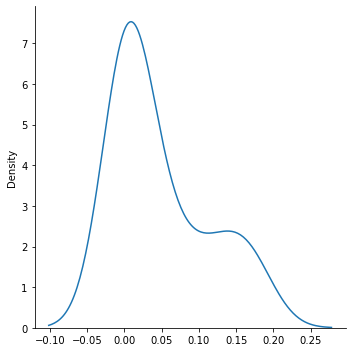

In [44]:
sns.displot(pmf, kind='kde')

### Using BorutaPy in Python

In [48]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

forest = RandomForestRegressor(n_jobs=-1, max_depth=5)

boruta = BorutaPy(estimator = forest,
                 n_estimators = 'auto',
                 max_iter = 100)
boruta.fit(np.array(X), np.array(y))

# print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: []
features in the blue area: []
